# Lab 2: Spatial Statistics (_and Lab 3: Web Cartography to AGOL_)

### Neighborhood Resurrection, Part 1: _Mapping a refugee route to Sudan in 1980s Ethiopia_

#### Lab 2 Objectives and Workflow:
This script begins to utilize ArcGIS spatial statistics and analytic tools to build a least cost corridor.

#### Lab 3 Workflow:
Code to export map as packaged web map to ArcGIS Online for further storymapping

#### The Workflow includes the following:
1. Calculating [Surface Cost](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/adjust-the-encountered-distance-using-a-cost-surface.htm) for elevation and conflict (using [Kernel Density](https://pro.arcgis.com/en/pro-app/3.4/tool-reference/spatial-analyst/kernel-density.htm) and exponential function for conflict from point/feature layer data)
2. Using [Raster Calculator](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-raster-calculator-works.htm) to join the surface costs
3. Running a [Distance Accumulation](https://pro.arcgis.com/en/pro-app/3.4/tool-reference/spatial-analyst/distance-accumulation.htm) for both Addis Abeba and Khartoum (to retrieve _Distance Cost_ and _Direction Cost_ rasters for each)
4. Taking outputs from Distance Accumulation to run a [Least Cost Corridor](https://pro.arcgis.com/en/pro-app/3.4/tool-reference/spatial-analyst/least-cost-corridor.htm) ([ESRI Tut](https://www.esri.com/arcgis-blog/products/arcgis-pro/analytics/create-a-wildlife-corridor-with-the-new-least-cost-corridor-tool-in-arcgis-pro))

##### Notes:
1. Save all to corridor_project.gdb
2. Save cost surface without weighting elevation and conflict as:
   1. CS = base + elevation + conflict
3. Run distance accumulation for Addis and Khartoum
    1. Addis Distance: DIST_add.tif
    2. Addis Direction: DIR_add.tif
    3. Khartoum: DIST_khar.tif
    4. Khartoum Direction: DIR_khar.tif
4. LCC: lcc_2

In [17]:
arcpy.env.workspace = r"G:\My Drive\Corridor_Project\Outputs"
arcpy.env.overwriteOutput = True
arcpy.env.compression = "LZ77"
arcpy.env.cellSize = "dem_reprojected.tif"
arcpy.env.extent = "dem_reprojected.tif"

In [15]:
import arcpy
from arcpy import env
from arcpy.sa import *

## Notes to Understand the Data
##### *_Conflict Data is from 1989-1995 and only includes instances where casualties >25_
### [Codebook+](https://ucdp.uu.se/downloads/ged/ged251.pdf)

1. _Type of Violence_
   1. '1' == State-based conflict (conflict that concerns government and/or territory, at least one side {Side A} is the government of a state)
   3. '2' == Non-state conflict (communal/organized conflict where none of the parties is a government or recognized state _at the time of conflict event_)
   4. '3' == One-sided violence (intentional attacks on civilians by governments and formally organized groups)

2. _'Dyad'_ == Pair of the actors engaged in the conflict. In the case on one-sided violence, the perpetrator of violence

3. _Fatality Figures_ == UCDP notes that estimates on fatalities sustained per category is pulled from sometimes ambiguous terms/translations. Figure estimates may be imprecise at the segregated level, so _best_est_ is used.

### Cost Surfaces
##### ***Base cost***: To standardize cost of each cell (constant value of 1) for later weighting analysis using Raster Calculator GP tool (set = 1)
##### ***Confict Cost***: To model density of conflict, creating a generalized surface measuring 'danger' using Kernal Density _(+ exp multiplier ==> high risk aversion)_
##### ***Elevation Cost***: _Not_ slope. See below.

-----
##### ***Raster Calculator***: 
###### _combining costs (potentially weighting conflict higher than elevation)_

#### Elevation cost
###### _The model automatically penalizes higher elevation, but refugees in Addis Ababa are already starting at a higher elevation. Because of this, we will neautralize for the minimum and maximum by using the relative elevation_

In [9]:
dem = Raster(r"G:\My Drive\Corridor_Project\Processed_Data\dem_reprojected.tif")

In [10]:
dem_min = float(arcpy.GetRasterProperties_management(dem, "MINIMUM").getOutput(0))
dem_max = float(arcpy.GetRasterProperties_management(dem, "MAXIMUM").getOutput(0))

print(f"Minimum elev in study area: {dem_min}m")
print(f"Maximum elev in study area: {dem_max}m")

Minimum elev in study area: -214.0m
Maximum elev in study area: 4529.0m


In [10]:
rel = dem - dem_min
el_cost = (rel / 1000) * 10
elevation_cost = Con(el_cost > 50, 50, el_cost)

elevation_cost.save(r"G:\My Drive\Corridor_Project\Processed_Data\elevation_cost.tif")

#### Conflict cost

In [ ]:
with arcpy.EnvManager(scratchWorkspace=r"C:\GIS_scratch"):
    out_raster = arcpy.sa.KernelDensity(
        in_features=r"G:\My Drive\Corridor_Project\combined_conflict.shp",
        population_field="best_est",
        cell_size=250,
        search_radius=20000,
        area_unit_scale_factor="SQUARE_KILOMETERS",
        out_cell_values="DENSITIES",
        method="PLANAR",
        in_barriers=None
    )
    out_raster.save(r"C:\GIS_scratch\kd_conflict")

##### Applying exponential function to conflict cost raster to estimate high risk aversion

In [8]:
## applying exponential function
kd = Raster(r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\kd_conflict")

In [9]:
exp_conflict_cost = Exp(kd * 0.1) * 10
exp_output = r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\exp_cost"
exp_conflict_cost.save(r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\exp_output")

In [ ]:
## (use GUI guide below to avoid frozen notebooks)

In [ ]:
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["WGS_1984_UTM_Zone_36N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",33.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]', extent='30.9194831920611 7.42733769769874 41.3159434973917 17.6624758700506 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]', cellSize=250, scratchWorkspace=r"G:\My Drive\Corridor_Project\arc\2Lab.gdb"):
    output_raster = arcpy.sa.RasterCalculator(
        expression=' Exp("kd_conflict" *0.1)*10'
    )
    output_raster.save(r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\exp_cost")

In [ ]:
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["WGS_1984_UTM_Zone_36N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",33.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]', extent='30.9194831920611 7.42733769769874 41.3159434973917 17.6624758700506 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]', cellSize=250, scratchWorkspace=r"G:\My Drive\Corridor_Project\arc\2Lab.gdb"):
    output_raster = arcpy.sa.RasterCalculator(
        expression=' Power("kd_conflict"+ 1, 3)'
    )
    output_raster.save(r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\cub_cost")

In [ ]:
# euclidean distance to nearest conflict: Just for analysis
print("Calculating distance to nearest conflict...")
# Use output cell size of 250m for speed
distance_raster = EucDistance(conflict_local, cell_size=250, maximum_distance=100000)
distance_raster.save(os.path.join(local_temp, "distance_to_conflict.tif"))
print(f"Distance range: {distance_raster.minimum} to {distance_raster.maximum} meters")

### Final cost

***Note*** Original code sought to weight conflict more than elevation (base + (conflict_cost * 0.7) + (elevation_cost * 0.3)), but doing so may disrupt distance accumulation raster not weighting elevation _enough_. Value range for conflict cost is already much higher (10-462) compared to elevation cost (0-47). Thus, only weight conflict higher if values are normalized to be on similar ranges. See below "Notes on Choices" for more

In [8]:
base = Raster(r"G:\My Drive\Corridor_Project\Processed_Data\base_cost.tif")
conflict = Raster(r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\exp_cost")
elevation = Raster(r"G:\My Drive\Corridor_Project\Processed_Data\elevation_cost.tif")

In [ ]:
with arcpy.EnvManager(scratchWorkspace=r"C:\GIS_scratch"):
    output_raster = arcpy.ia.RasterCalculator(
        expression=r' "Cost Layers\exp_cost" + "Cost Layers\elevation_cost" + "Cost Layers\base_cost.tif"'
    )
    output_raster.save(r"C:\GIS_scratch\cs")

In [ ]:
cost_surface = base + (conflict * 0.7) + (elevation * 0.3)
cost_surface.save(r"G:\My Drive\Corridor_Project\Processed_Data\cost_surface.tif")

In [ ]:
## Reprojecting to 30m cell size for matching 

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["WGS_1984_UTM_Zone_36N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",33.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]', extent='30.9194831920611 7.42733769769874 41.3159434973917 17.6624758700506 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'):
    arcpy.management.Resample(
        in_raster=r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cost_surface",
        out_raster=r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\final_surface",
        cell_size="30.9704650839416 30.9704650839416",
        resampling_type="NEAREST"
    )

In [ ]:
## creating raster from shape file

In [ ]:
city = r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\city_points_XYTableToPoint"

In [12]:
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["WGS_1984_UTM_Zone_36N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",33.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]', cellSize="cost_surface"):
    arcpy.conversion.PointToRaster(
        in_features="city_points_XYTableToPoint",
        value_field="geom_wkt",
        out_rasterdataset=r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\cities",
        cell_assignment="MOST_FREQUENT",
        priority_field="NONE",
        cellsize=r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cost_surface",
        build_rat="DO_NOT_BUILD"
    )

### Distance Accumulation

In [13]:
## Addis layer, Khartoum layer
cost = r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cost_surface"
both = r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\city_points_XYTableToPoint"

In [ ]:
addis = arcpy.SelectLayerByAttribute_management(
    both,
    "NEW_SELECTION",
    "city = 'Addis Abeba'"
)

addis.save("addis")
## rename in contents as 'addis'

In [16]:
sudan = arcpy.SelectLayerByAttribute_management(
    both,
    "NEW_SELECTION",
    "city = 'Khartoum'"
)

## rename in contents as 'khartoum'

In [18]:
env.extent = r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cost_surface"
env.snapRaster = r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cost_surface"
env.mask = r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cost_surface"

In [ ]:
## Distance Accumulation from Addis

with arcpy.EnvManager(scratchWorkspace=r"C:\GIS_scratch"):
    out_distance_accumulation_raster = arcpy.sa.DistanceAccumulation(
        in_source_data=r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\addis",
        in_barrier_data=None,
        in_surface_raster=None,
        in_cost_raster=r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cs",
        in_vertical_raster=None,
        vertical_factor="BINARY 1 -30 30",
        in_horizontal_raster=None,
        horizontal_factor="BINARY 1 45",
        out_back_direction_raster=r"G:\My Drive\Corridor_Project\Processed_data\DIR_addis.tif",
        out_source_direction_raster=None,
        out_source_location_raster=None,
        source_initial_accumulation=None,
        source_maximum_accumulation=None,
        source_cost_multiplier=None,
        source_direction="FROM_SOURCE",
        distance_method="PLANAR"
    )
    out_distance_accumulation_raster.save(r"G:\My Drive\Corridor_Project\Processed_data\DIST_addis.tif")

In [ ]:
## Distance Accumulation from Khartoum

with arcpy.EnvManager(scratchWorkspace=r"C:\GIS_scratch"):
    out_distance_accumulation_raster = arcpy.sa.DistanceAccumulation(
        in_source_data=r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\sudan",
        in_barrier_data=None,
        in_surface_raster=None,
        in_cost_raster=r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cs",
        in_vertical_raster=None,
        vertical_factor="BINARY 1 -30 30",
        in_horizontal_raster=None,
        horizontal_factor="BINARY 1 45",
        out_back_direction_raster=r"G:\My Drive\Corridor_Project\Processed_datab\DIR_khar.tif",
        out_source_direction_raster=None,
        out_source_location_raster=None,
        source_initial_accumulation=None,
        source_maximum_accumulation=None,
        source_cost_multiplier=None,
        source_direction="FROM_SOURCE",
        distance_method="PLANAR"
    )
    out_distance_accumulation_raster.save(r"G:\My Drive\Corridor_Project\Processed_data\DIST_khar.tif")

In [ ]:
## Distance Accumulation for both cities (using 'cities' raster to see cross-path and validate that the corridor follows intersection

with arcpy.EnvManager(scratchWorkspace=r"G:\My Drive\Corridor_Project\Processed_Data"):
    out_distance_accumulation_raster = arcpy.sa.DistanceAccumulation(
        in_source_data=r"G:\My Drive\Corridor_Project\arc\2Lab.gdb\cities",
        in_barrier_data=None,
        in_surface_raster=None,
        in_cost_raster=r"G:\My Drive\Corridor_Project\arc\corridor_project.gdb\cs",
        in_vertical_raster=None,
        vertical_factor="BINARY 1 -30 30",
        in_horizontal_raster=None,
        horizontal_factor="BINARY 1 45",
        out_back_direction_raster=r"G:\My Drive\Corridor_Project\Processed_Data\DIR_combined.tif",
        out_source_direction_raster=None,
        out_source_location_raster=None,
        source_initial_accumulation=None,
        source_maximum_accumulation=None,
        source_cost_multiplier=None,
        source_direction="",
        distance_method="PLANAR"
    )
    out_distance_accumulation_raster.save(r"G:\My Drive\Corridor_Project\Processed_Data\DIST_combined.tif")

## Least Cost Corridor
##### ***Why does the corridor overlap with some conflicts?*** --> This can be adjusted with the _threshold_ field (5%-1%)

In [ ]:
with arcpy.EnvManager(scratchWorkspace=r"G:\My Drive\Corridor_Project\Processed_Data"):
    out_raster = arcpy.sa.LeastCostCorridor(
        in_accumulative_cost_distance_raster1=r"new attempt LCC\DIST_add.tif",
        in_back_direction_raster1=r"new attempt LCC\DIR_add.tif",
        in_accumulative_cost_distance_raster2=r"new attempt LCC\DIST_khar.tif",
        in_back_direction_raster2=r"new attempt LCC\DIR_khar.tif",
        threshold_method="PERCENT_OF_LEAST_COST",
        threshold=5
    )
    out_raster.save(r"G:\My Drive\Corridor_Project\Processed_Data\lcc_1.tif")

In [ ]:
with arcpy.EnvManager(scratchWorkspace=r"G:\My Drive\Corridor_Project\Processed_Data"):
    out_raster = arcpy.sa.LeastCostCorridor(
        in_accumulative_cost_distance_raster1=r"new attempt LCC\DIST_add.tif",
        in_back_direction_raster1=r"new attempt LCC\DIR_add.tif",
        in_accumulative_cost_distance_raster2=r"new attempt LCC\DIST_khar.tif",
        in_back_direction_raster2=r"new attempt LCC\DIR_khar.tif",
        threshold_method="PERCENT_OF_LEAST_COST",
        threshold=1 
    )
    out_raster.save(r"G:\My Drive\Corridor_Project\Processed_Data\lcc_2.tif")

## Notes on Choices:
### _Weighing [slope](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/adjust-the-encountered-distance-using-a-cost-surface.htm) as a feature:_
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Originally, my expectation was that elevation could not be comprehensive enough in determining the physical travel cost of moving from Addis Ababa to Khartoum for two reasons: 1. Considering directionality means taking into account that every possible route will require traversing through highlands that have slope variations at local levels (cliffs, steep mountains), and 2. As shown from the map, Addis Ababa is already higher in elevation than Khartoum, meaning past a certain point, the route will be generally downhill; but again, complex terrain means this path may not be consistent, and a feature such as _slope_ would need to be incorporated (this would also require vertical raster data). ***Slope*** considers directionality of movement as a cost (uphill == more costly, downhill== costly but less, perpendicular == least costly).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ***However***, with the inclusion of _conflict_ as a barrier to avoid and based on literature on the experiences of refugees that commute primarily by foot, it can be reasonably decided in this instance that avoiding conflict may be a more extreme factor in deciding direction than slope (meaning, the **easiest** route by slope to cross may not be the safest, and complex terrain, despite its high cost, is more likely. Survival is more important than efficiency). In this case, elevation as a weighted feature in the Least Cost Corridor captures some of the costs associated with moving from one place to the next, where higher elevation == higher cost; despite ignoring directionality, the tool still accounts for terrain by avoiding high elevation (proxy for uphill) secondarily to barriers.

## Least Cost Corridor

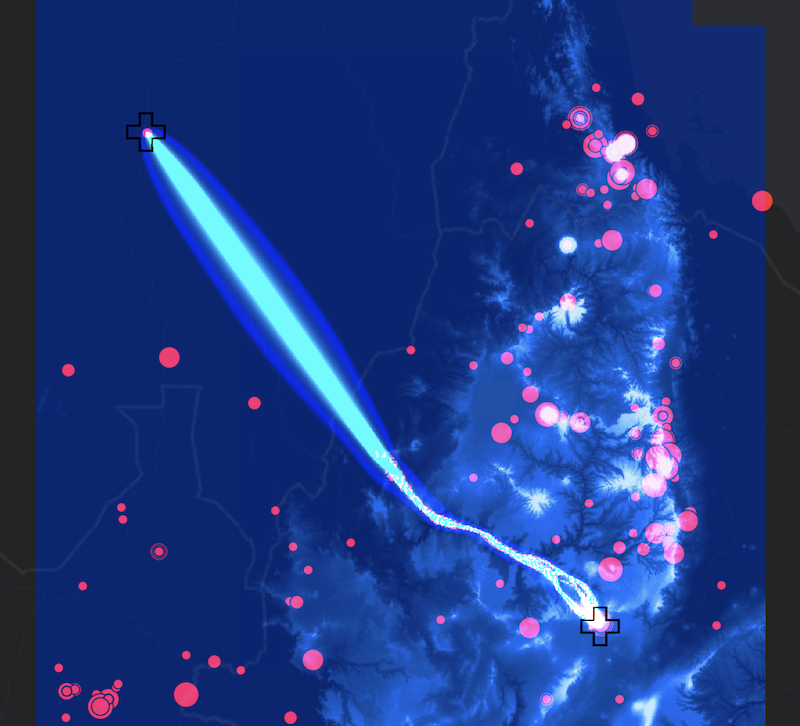

#### Elevation and Conflict Points

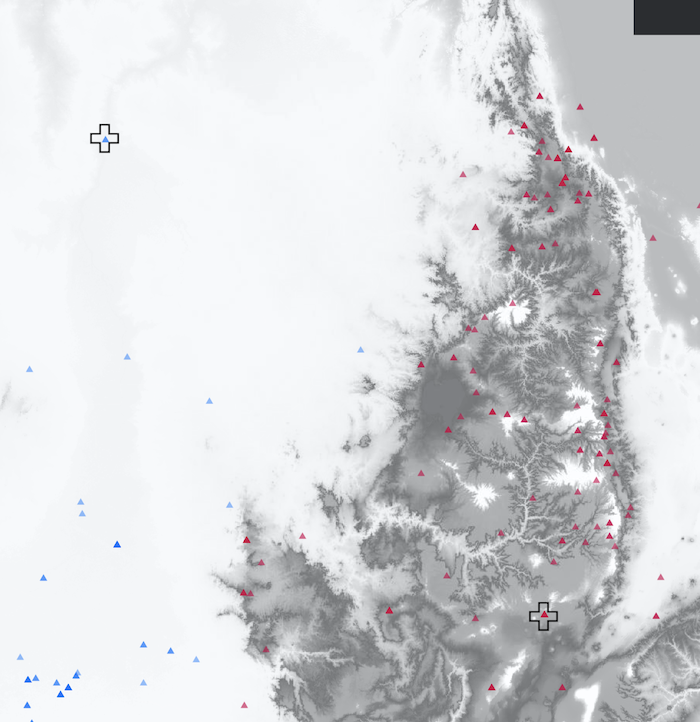

# Lab 3: Web Cartography Script
#### Using [ExportWebMap](https://pro.arcgis.com/en/pro-app/latest/tool-reference/server/export-web-map.htm) script

In [ ]:
arcpy.server.ExportWebMap(Web_Map_as_JSON, "Corridor_Project.tif", {TIFF})